<a href="https://colab.research.google.com/github/gabrielxmit10/Repository_Telecom_Trab_EEG/blob/main/EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEG Analysis Notebook — PhysioNet (Motor Movement/Imagery) + CHB-MIT (seizure detection)

Este notebook 2 blocos principais:
1) Pipeline com o dataset *EEG Motor Movement/Imagery* (PhysioNet / BCI2000) cobrindo:
 - leitura e pré-processamento (filtragem, notch)
 - PSD / bandpower por banda + topomapas
 - espectrograma (STFT) e scalogram (CWT)
 - ICA: identificação e remoção de artefatos (ex.: piscadas)
 - ERP / média por evento (quando aplicável)
 2) Notebook curto para detecção de crises (CHB-MIT):
 - leitura de EDFs (exige download manual ou upload para Colab)
 - extração de features (bandpower, entropia, RMS)
 - classificação simples (RandomForest) em janelas

 Cite: Este notebook usa MNE-Python para manipulação de EEG, PyWavelets para CWT e scikit-learn para ML.





In [1]:
#  0) Instalação das dependências

!pip install mne==1.4.2 pyedflib pywavelets scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.8 MB/s eta 0:00:00


In [3]:
# 1) Importação de bibliotecas

import os # Used for interacting with the operating system
import numpy as np # Fundamental package for scientific computing (arrays, math)
import matplotlib.pyplot as plt # For creating plots and visualizations
import seaborn as sns # High-level interface for drawing statistical graphics
sns.set(style='whitegrid') # Sets the style of seaborn plots

import mne # Main library for MEG/EEG data analysis
from mne.time_frequency import psd_array_welch # Function for computing Power Spectral Density (PSD)
PSD_FUNC = psd_array_welch # Assign PSD function to a variable
from mne.preprocessing import ICA, create_eog_epochs # ICA for artifact removal, create_eog_epochs for eye-blink event handling
from mne.channels import make_standard_montage # For creating standard electrode montages

import pywt # Library for wavelet transforms (e.g., Continuous Wavelet Transform)
from scipy.signal import spectrogram # Function for computing spectrograms (Short-Time Fourier Transform)

from sklearn.model_selection import train_test_split # For splitting data into training and testing sets
from sklearn.ensemble import RandomForestClassifier # Random Forest classification model
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report # Metrics for evaluating classification models

print('mne version:', mne.__version__) # Print the version of the MNE library

mne version: 1.4.2


/root/mne_data/MNE-sample-data
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


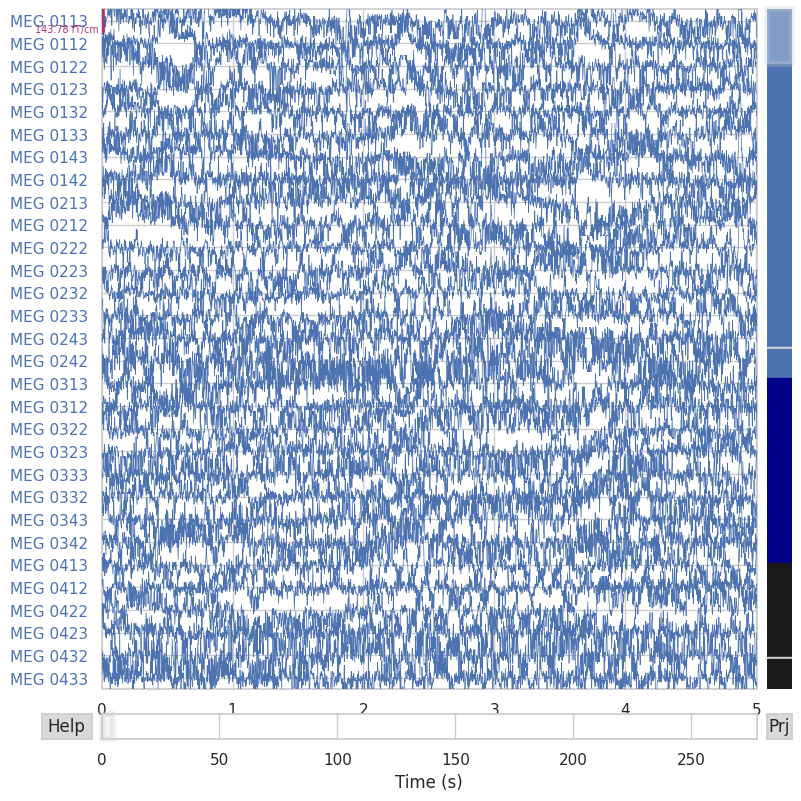

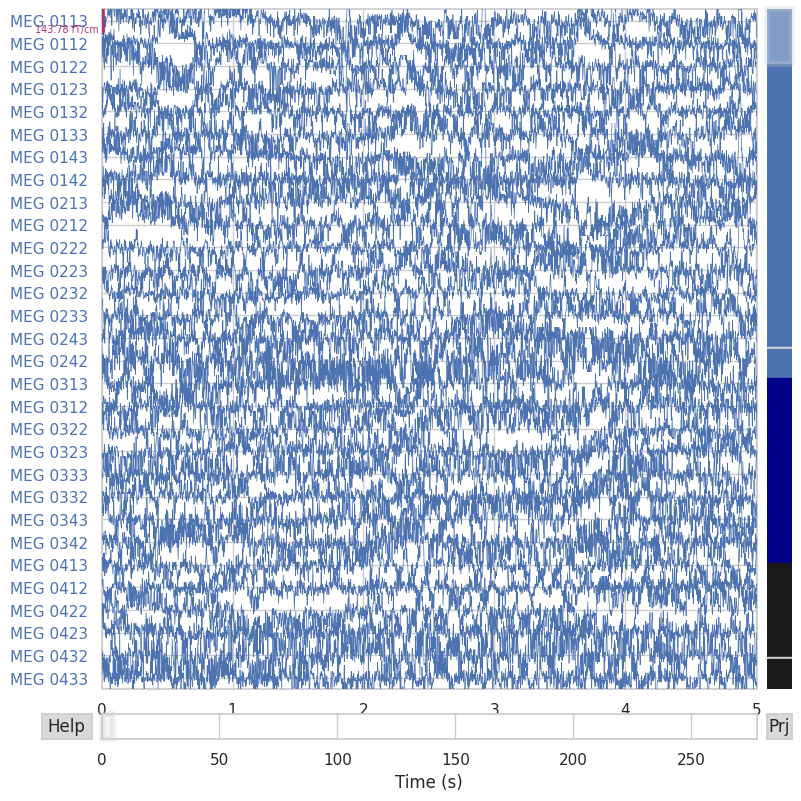

In [8]:
## 📥 Load EEG Data from PhysioNet


# Load sample EEG from PhysioNet: https://physionet.org/content/eegmmidb/1.0.0
sample_data_folder = mne.datasets.sample.data_path()
print(sample_data_folder)
raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_raw.fif') # Corrected file path
raw = mne.io.read_raw_fif(raw_file, preload=True) # Changed to read .fif file

# sth

# Basic info
raw.info
raw.plot(duration=5, n_channels=30, scalings='auto')

In [ ]:
## 🧹 Preprocessing and Filtering

raw.load_data()

# Filtro passa-banda (tipicamente 1–40 Hz EEG)
raw.filter(1., 40., fir_design='firwin')

# Correção da nomeclatura dos canais
channel_names = raw.info['ch_names']
mapping = {name: name.replace('.', '') for name in channel_names}
raw.rename_channels(mapping)

# Definição da montagem 1020
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)

# Artifact detection using ICA
from mne.preprocessing import ICA, create_eog_epochs
ica = ICA(n_components=15, random_state=97)
ica.fit(raw)
ica.plot_components()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


ValueError: DigMontage is only a subset of info. There are 28 channel positions not present in the DigMontage. The channels missing from the montage are:

['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'Ft7', 'Ft8', 'Tp7', 'Tp8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

Effective window size : 1.600 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


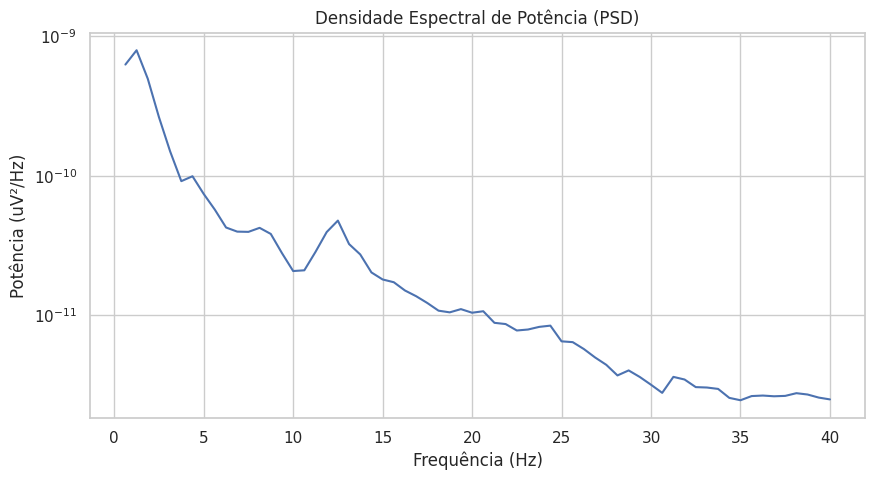

In [ ]:
## ⚡ Power Spectral Density (PSD) Analysis

# Compute Power Spectral Density using Welch’s method
psds, freqs = PSD_FUNC(raw.get_data(), sfreq=raw.info['sfreq'], fmin=0.5, fmax=40)

# Average and plot
plt.figure(figsize=(10,5))
plt.semilogy(freqs, np.mean(psds, axis=0))
plt.title('Densidade Espectral de Potência (PSD)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Potência (uV²/Hz)')
plt.grid(True)
plt.show()


Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)
Effective window size : 1.600 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


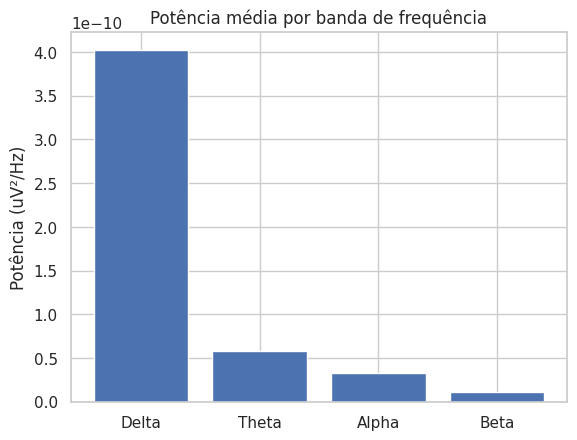

In [ ]:
## 🔍 Frequency Band Analysis (Delta, Theta, Alpha, Beta)

bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30)}

band_powers = {}
for band, (low, high) in bands.items():
    psd, freqs = PSD_FUNC(raw.get_data(), sfreq=raw.info['sfreq'], fmin=low, fmax=high)
    band_powers[band] = np.mean(psd)

plt.bar(band_powers.keys(), band_powers.values())
plt.title('Potência média por banda de frequência')
plt.ylabel('Potência (uV²/Hz)')
plt.show()


In [ ]:
## 🧭 Topographic Visualization

# Compute PSD for topomap visualization
psds, freqs = PSD_FUNC(raw,  sfreq=raw.info['sfreq'], fmin=8, fmax=13, n_fft=2048)
psd_mean = np.mean(psds, axis=1)

# Create topomap
mne.viz.plot_topomap(psd_mean, raw.info, cmap='viridis', contours=0)
plt.title('Topografia da Banda Alfa (8–13 Hz)')
plt.show()


AttributeError: 'RawEDF' object has no attribute 'shape'

In [ ]:
## 📈 Event Detection Example (Blink / EOG)

# Create epochs for eye-blink events (if EOG channels exist)
eog_epochs = create_eog_epochs(raw, ch_name='EOG 061')
eog_evoked = eog_epochs.average()
eog_evoked.plot_joint(title='Resposta média a piscadas (EOG)')